In [112]:
from chainer import optimizer, optimizers, iterators, training, Variable, Chain
from chainer.training import extensions
import chainer.functions as F
import chainer.links as L
import chainer

import numpy as np
import matplotlib.pyplot as plt

In [113]:
NT_train = 500 # 学習に使う周期数
NP_per_T = 20 # 周期ごとのサンプル点数
x = np.linspace(0, NT_train*2*np.pi, NT_train*NP_per_T) 
y = (np.sin(x)*128 + 128).astype(np.uint8) # クラス分類問題にするため、大雑把に量子化
# wavenetの論文ではμ-lawアルゴリズムによってよりよい復元が得られる量子化を行っているようですが、今回はそもそも
# 量子化されたデータの予測を目指す問題にします ←　あとで考え直す

In [126]:
N_recep = 16 # 受容野の広さ
train = []
for i in range(NT_train*NP_per_T - N_recep):
    train.append((y[i:i+N_recep].astype(np.float32), y[i+N_recep].astype(np.int32)))

In [127]:
# イテレータの作成
batchsize = 64
train_itr = iterators.SerialIterator(train, batchsize)

In [128]:
# 比較用の多層パーセプトロン
class MLP(Chain):
    
    def __init__(self, n_mid_unit = 100):
        super(MLP, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(N_recep, n_mid_unit)
            self.l2 = L.Linear(n_mid_unit, n_mid_unit)
            self.l3 = L.Linear(n_mid_unit, 256)
    
    def __call__(self, x):
        h = F.relu(self.l1(x))
        h = F.relu(self.l2(h))
        h = self.l3(h)
        return h

In [146]:
def train(model_object, max_epoch):
    train_itr.epoch = 0
    
    model = L.Classifier(model_object)
    optimizer = optimizers.Adam()
    optimizer.setup(model)

    gpu_id = -1
    if gpu_id >= 0:
        model.to_gpu(gpu_id)
    
    updater = training.StandardUpdater(train_itr, optimizer, device=gpu_id)
    
    trainer = training.Trainer(updater, (max_epoch, 'epoch'), out='{}_result'.format(model_object.__class__.__name__))
    trainer.extend(extensions.LogReport())
    trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'main/accuracy', 'elapsed_time']))
    trainer.extend(extensions.PlotReport(['main/loss'], x_key='epoch', file_name='loss.png'))
    trainer.extend(extensions.PlotReport(['main/accuracy'], x_key='epoch', file_name='accuracy.png'))
    
    trainer.run()  
    del trainer
    
    return model

In [148]:
train(MLP(), 20)

epoch       main/loss   main/accuracy  elapsed_time
1           25.2408     0.0293236      0.846408      
2           4.89569     0.0573918      1.88955       
3           4.68468     0.0849359      2.95375       
4           4.50854     0.0921474      4.20134       
5           4.37234     0.0941506      5.57081       
6           4.2404      0.0997596      6.98862       
7           4.08864     0.101663       8.34331       
8           3.98116     0.11228        9.91151       
9           3.87503     0.11869        11.3029       
10          3.79351     0.129307       12.7701       
11          3.71116     0.130809       14.5822       
12          3.6423      0.142428       16.3552       
13          3.57762     0.149038       18.0579       
14          3.52483     0.159655       19.5302       
15          3.4721      0.165264       21.1045       
16          3.44072     0.169471       22.6588       
17          3.38763     0.183894       24.1109       
18          3.34681     0.1820

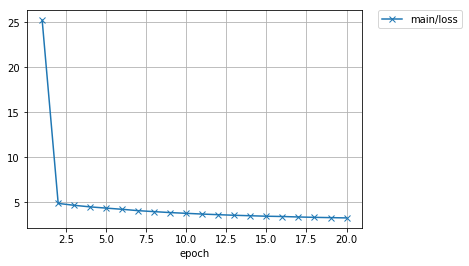

In [153]:
from IPython.display import Image
Image(filename='MLP_result/loss.png')

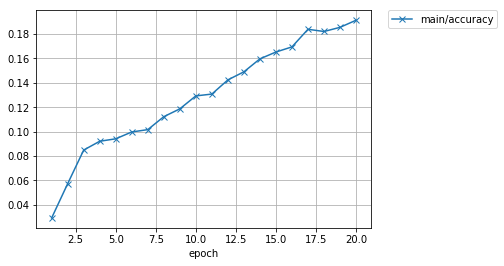

In [154]:
Image(filename='MLP_result/accuracy.png')